In [16]:
# load data/PEMS-BAY-META.csv and get Lattitude and Longitude
import pandas as pd

df = pd.read_csv('data/METR-LA-META.csv')

# df = df.sort_values(by='sensor_id')
df


,index,sensor_id,Latitude,Longitude
0,0,773869,34.15497,-118.31829
1,1,767541,34.11621,-118.23799
2,2,767542,34.11641,-118.23819
3,3,717447,34.07248,-118.26772
4,4,717446,34.07142,-118.26572
...,...,...,...,...
202,202,717592,34.14604,-118.22430
203,203,717595,34.14163,-118.18290
204,204,772168,34.16542,-118.47985
205,205,718141,34.15133,-118.37456


207


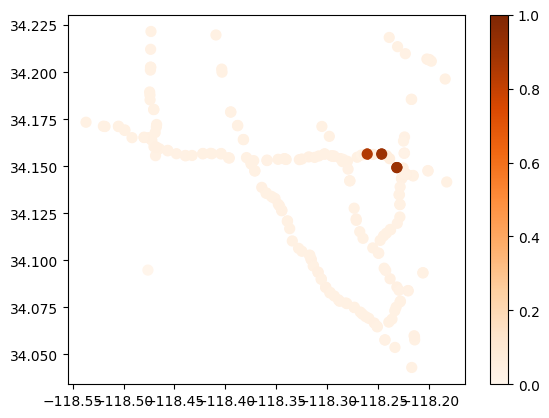

In [17]:
# laod node_mask.pt and get the mask
import torch

mask = torch.load('node_mask.pt')
print(len(mask))

# colorize the points using the mask, assume the mask is a tensor of shape (N, 1) with the same order as the data
import matplotlib.pyplot as plt

df["mask"] = mask.cpu().numpy().flatten()

df_importants = df[df['mask'] > 0.25]


plt.scatter(df['Longitude'], df['Latitude'], c=df['mask'], s=50, vmin=0, vmax=1, cmap='Oranges')
plt.scatter(df_importants['Longitude'], df_importants['Latitude'], c=df_importants['mask'], s=50, vmin=0, vmax=1, cmap='Oranges')
plt.colorbar()
plt.show()





In [18]:
from src.data import get_pems_bay_dataset, get_metr_la_dataset


dataset = get_metr_la_dataset()

In [19]:
dataset[100]

Data(x=[207, 1, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 1, 12])

In [20]:
node_features = 1
out_channels = 32
K = 3

In [21]:
from src.model.dcrnn import DCRNN


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = DCRNN(node_features=node_features, out_channels=out_channels, K=K).to(
    device
)

Using device: cuda


In [22]:
params = torch.load("runs/model_checkpoint_dcrnn_no_skip.pth")

In [23]:
model.load_state_dict(params["model_state_dict"])

<All keys matched successfully>

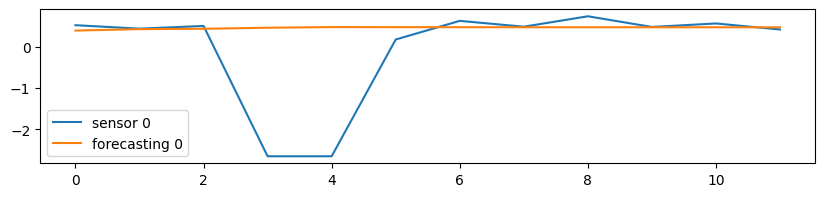

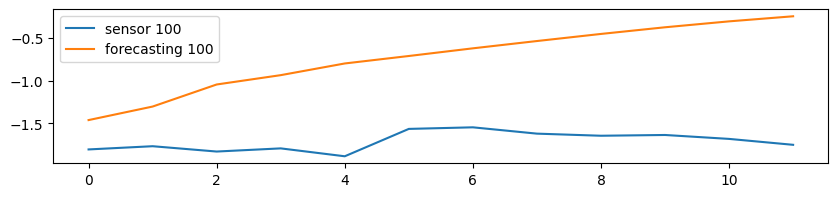

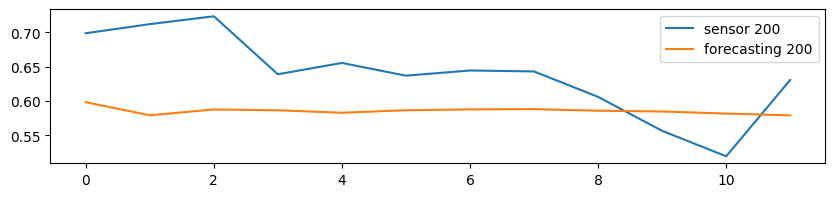

In [24]:
sensors = [0, 100, 200]


def plot_forecasting(dataset, sensors):
    with torch.no_grad():
        for sensor in sensors:
            data = dataset[sensor]
            output = model(data.x.unsqueeze(0).to(device), data.edge_index.to(device), data.edge_attr.to(device))
            plt.figure(figsize=(10, 2))
            plt.plot(data.x[sensor, :].numpy().flatten(), label=f"sensor {sensor}")
            plt.plot(output[0, sensor].cpu().numpy().flatten(), label=f"forecasting {sensor}")
            plt.legend()
            plt.show()

plot_forecasting(dataset, sensors)

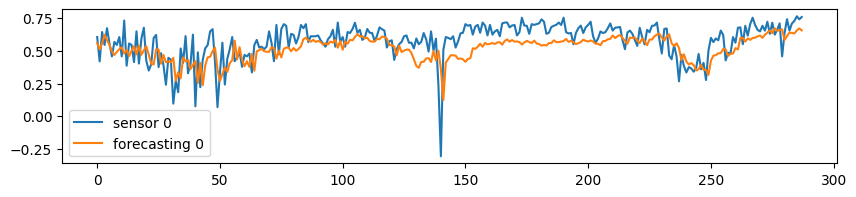

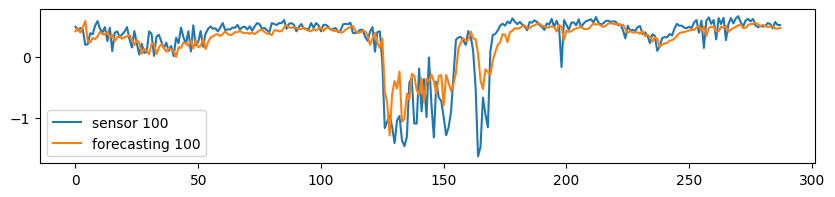

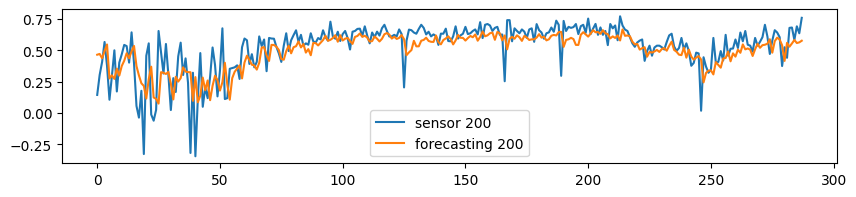

In [35]:
import torch
import matplotlib.pyplot as plt

samples_per_hour = 12
day_samples = 24 * samples_per_hour
sample_to_forecast = 11

sensors = [0, 100, 200]
day = 30

def plot_forecasting_2(dataset, sensors, batch_size):
    with torch.no_grad():
        for sensor in sensors:
            reals = []
            outputs = []
            
            # Gather batch data
            batch_data = [dataset[i] for i in range(day*day_samples, (day+1)*day_samples)]
            batch_x = torch.stack([data.x for data in batch_data]).to(device)
            batch_edge_index = torch.stack([data.edge_index for data in batch_data]).to(device)
            batch_edge_attr = torch.stack([data.edge_attr for data in batch_data]).to(device)
            
            # Perform model inference in batches
            batch_output = model(batch_x, batch_edge_index[0], batch_edge_attr[0])
            
            for i in range(day_samples):
                real_sample_to_forecast = batch_data[i].y[sensor, :].cpu().numpy().flatten()[0]
                output_sample_to_forecast = batch_output[i, sensor].cpu().numpy().flatten()[sample_to_forecast]

                reals.append(real_sample_to_forecast)
                outputs.append(output_sample_to_forecast)
                
                print(f"{i}/{day_samples}", end="\r")
            
            plt.figure(figsize=(10, 2))
            plt.plot(reals, label=f"sensor {sensor}")
            plt.plot(outputs, label=f"forecasting {sensor}")
            plt.legend()
            plt.show()

# Assuming batch_size is the total number of samples to be processed
batch_size = day_samples
plot_forecasting_2(dataset, sensors, batch_size)
